# Part 1: Data wrangling and model training

# Emotion recognition

The goal of this task is to detect emotion in language. This can be used to learn how customers feel about a project or for mental health experts to find out what the emotional state of a patient is through analysis of recorded therapy calls, for example. To do so, we will train a standard BERT model on the emotions dataset, a collection of tweets that include a range of emotions such as joy, sadness, anger, and disgust.

### First, get all dependencies

In [1]:
!pip install datasets umap-learn
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 1.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (4

# Load the emotions dataset

<a href="https://www.huggingface.co">Hugging Face</a> is a great resource for finding datasets. Additionally, they offer a library called "datasets" that allows users to load any dataset from their hub in a single line of code, as below.

In [2]:
from datasets import load_dataset

emotions = load_dataset("emotion")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

### Have a look at the dataset

We can see there are 20k examples, split into an 80-10-10 train-test-validation split. We also see that the features contained in the dataset are some text and the corresponding label.

In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

### Look closer at the train split

In [6]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

### Look at the first training example

We see that 'text' is an all lowercase string. Label is a categorical label corresponding to an index in a list of class labels. Let us try and see what that label corresponds to.

In [7]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

### View the string for each label

Here we investigate the features more. We see that the label list is [sadness, joy, etc.]. So for our previous example, 0 corresponds to sadness, which matches the emotion in the sentence.

In [8]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


### Examine the first five examples from the dataset

In [9]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


### Change Hugging Face Arrow dataset to Pandas format for visualization

The Hugging Face format is fast for performing cleaning, splits, and modifications, but to visualize the data, it is best to use Pandas. We can switch over the format quickly using the set_format function provided by Hugging Face.

In [10]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


### Add a column with label string for interpretability

In the pandas dataframe, we add an additional column with the label's string for interpretability and better visualization.

In [11]:
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Import matplotlib and visualize the portion of data in each class

The above bar chart shows that the data is imbalanced; joy and sadness appear much more than the other classes... We could compensate for this by oversampling the less represented classes, but for this project, we will keep the dataset as it is.

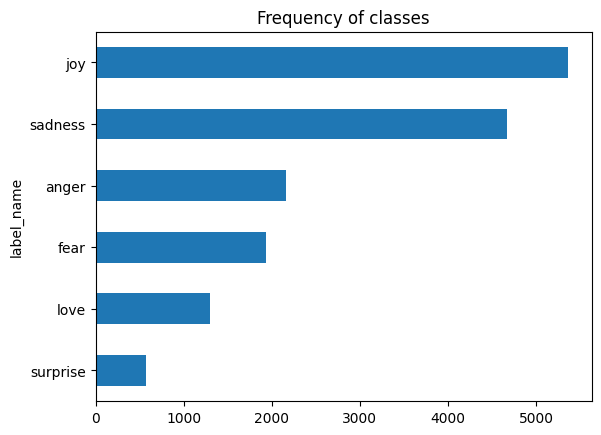

In [12]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of classes")
plt.show()

### Boxplot visualization

Let's continue visualizing the data by getting an idea of the range of length for our tweets.

It looks like we have an average length of about 15 words per tweet and this is fairly homogenous across all classes. Great!

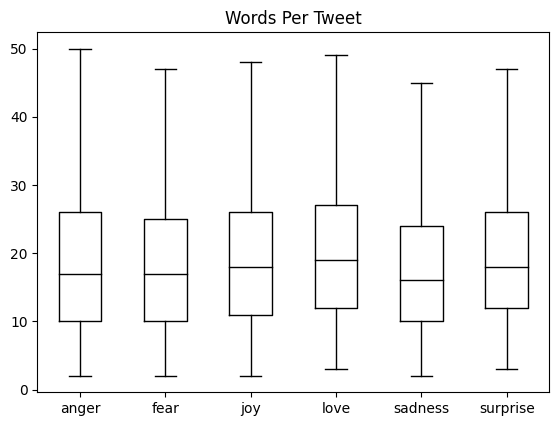

In [13]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
           showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

We will now go back to the Arrow format.

In [14]:
emotions.reset_format()

### We now load a tokenizer to convert our text to a numerical representation

In [15]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Convert a sample sentence to numerical representation and view it in tokenized format

In [16]:
text = "Machine learning is a fascinating subject."
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 3698, 4083, 2003, 1037, 17160, 3395, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


### We can convert the integer representation back to textual format in the following way

Note that CLS and SEP are special tokens. CLS indicates the beginning of a sequence and SEP the end.

In [17]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'machine', 'learning', 'is', 'a', 'fascinating', 'subject', '.', '[SEP]']


### Tokenization function to batch convert our dataset to a tokenized format

In [18]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

### See what tokenizing the first 2 training examples looks like, including tokenized portion and attention mask to indicate padded tokens

Note: When the attention mask for a given index is 0, this means that the model should ignore the token, since the token in the input_ids corresponds to a padding token, added to ensure all vectors have the same length.

In [19]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


### Tokenize all splits of the dataset

We use the map function. The library is written in Rust, which allows for parallelization. When this is run, it applies the function using multiple threads, which can greatly speed up operations when the datset is large.

In [20]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Since we're done adding new tokens to our tokenizer's representation, we can save the tokenizer for when we want to load the model later during inference.

In [ ]:
# Please set your own local directory or a place on colab where you would like to save!
tokenizer.save_pretrained('./drive/MyDrive/nlp_api/{model_name}/checkpoint-500')

### One version of a model with feature extraction (training a neural layer to do classification for us rather than fine tuning)

In [22]:
import torch
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"

# Boilerplate check to see if we are on a GPU or CPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Sends model to that device
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

### Get embeddings for a test sentence and take a look at the tensor's shape

In [23]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


### Observe the hidden state for our test input, dispensing with gradient computation to save on memory during inference via torch.no_grad(). The hidden state is an embedding of the sentence computed on a single token in the sentence.

In [24]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
  outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


### We note that BERT uses 768-dimensional vectors, which can store a lot of information about our tokens

In [25]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

### Get the final hidden state for a sentence

In [26]:
def extract_hidden_states(batch):
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [27]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

### Get the final hidden state for each example

In [28]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

### Create a feature matrix

In [30]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

### Perform dimensionality reduction on the inputs, scale the data to (0-1), and show in tabular format, using cosine similarity to denote distances

In [31]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,4.331266,6.999515,0
1,-3.002886,5.919624,0
2,5.331180,3.613739,3
3,-2.106847,3.955427,2
4,-3.324630,3.837885,3


### We visualize the data in a low-dimensional space. We can see that there is overlap between certain emotions. Sadness and anger might be confused with one another, as well as joy and love. Essentially, negative emotions cluster together and positive ones do too. There can be a lot of related vocabulary across these similar emotions.

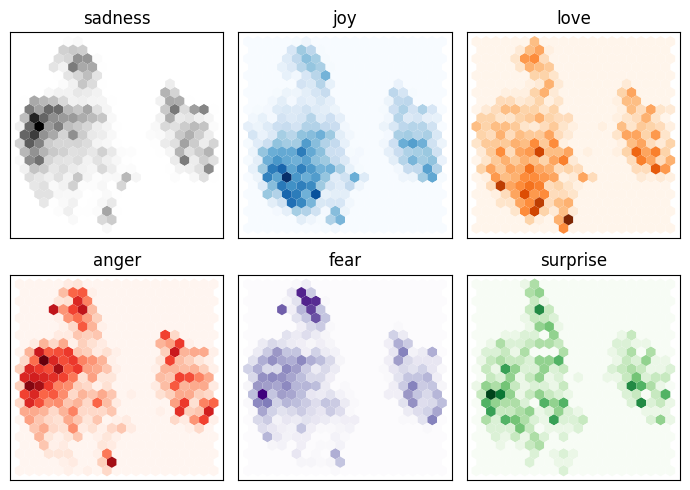

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_emb_sub = df_emb.query(f"label == {i}")
  axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                 gridsize=20, linewidths=(0,))
  axes[i].set_title(label)
  axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

### See how we perform with a vanilla logistic regression model trained on our data using a feature-based approach

Accuracy is at 63.4%. Is this good? Bad? How can we tell?

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [40]:
print(f"Accuracy of the feature-based logistic regression model: {lr_clf.score(X_valid, y_valid)}")
print(f"F1 of the feature-based logistic regression model: {f1_score(y_valid, lr_clf.predict(X_valid), average='weighted')}")

Accuracy of the feature-based logistic regression model: 0.634
F1 of the feature-based logistic regression model: 0.6218472849726772


### Compare with a dummy classifier that predicts the majority class each time. We can see that the performance of our logistic regression classifier is much better.

Looks like we are much better than random, at about 200% greater accuracy than a dummy classifier. This is commendable, but can we do better?

In [41]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

0.352

In [45]:
print(f"Accuracy of the dummy classifier baseline model: {dummy_clf.score(X_valid, y_valid)}")
print(f"F1 of the dummy classifier baseline model: {f1_score(y_valid, dummy_clf.predict(X_valid), average='weighted')}")

Accuracy of the dummy classifier baseline model: 0.352
F1 of the dummy classifier baseline model: 0.18328994082840236


### Plot the confusion matrix for the feature method

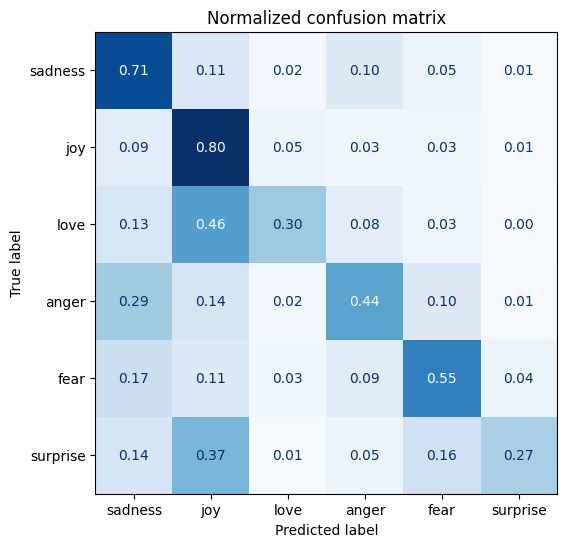

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### Now we will train a transformer model using the deep learning approach. We first instantiate a BERT model with 6 labels for our emotion multiclass classification.

In [ ]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### We define a function to compute metrics while training our model

We will include accuracy and F1 score to guide us in analyzing our model's progress during training and potentially debug it.

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

### We will mount the Google Drive so that the model can be saved locally for use later

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### We set our training arguments (number of epochs, learning rate, regularization, and so on)

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"])
model_name = f"{model_ckpt}-finetuned-emotion"
# Be sure to set your own local or Colab directory
output_dir = f'./drive/MyDrive/nlp_api/{model_name}'
training_args = TrainingArguments(output_dir=output_dir,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

### We indicate which splits correspond to our training and evaluation sets and launch the training process.

We also indicate a tokenizer and the function we defined to compute metrics.

In [ ]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)

trainer.train();

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.301669,0.911500,0.911022
2,No log,0.214192,0.923000,0.922893


# Part 2: Model Evaluation

### Run this if reloading the notebook after model has been trained

In [ ]:
!pip install datasets accelerate -U

### Load back up our model, tokenizer, and set GPU if we have one

In [ ]:
from google.colab import drive
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

model_ckpt = "distilbert-base-uncased"
model_name = f"{model_ckpt}-finetuned-emotion"
drive.mount('/content/drive')
# Please choose a local or Colab directory where you woud like to save
dir = f'./drive/MyDrive/nlp_api/{model_name}/checkpoint-500'

# This allows us to use the GPU if one is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(dir).to(device)
tokenizer = AutoTokenizer.from_pretrained(f'./drive/MyDrive/nlp_api/{model_name}/checkpoint-500')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### The next four cells are run to get back functions, parameters, and the dataset if the notebook was loaded from the middle

In [ ]:
def tokenize(batch):
  return tokenizer(batch["text"], padding=True, truncation=True)

In [ ]:
from datasets import load_dataset

emotions = load_dataset("emotion")

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(output_dir=output_dir,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


### Batch predict the entire validation dataset so we can evaluate it

In [ ]:
preds_output = trainer.predict(emotions_encoded["validation"])

### Obtain the metrics computed on the predicted dataset

In [ ]:
preds_output.metrics

{'test_loss': 0.21419167518615723,
 'test_accuracy': 0.923,
 'test_f1': 0.9228928639785935,
 'test_runtime': 5.3497,
 'test_samples_per_second': 373.856,
 'test_steps_per_second': 5.982}

### Select the most likely class using argmax from each prediction array

In [ ]:
import numpy as np
y_preds = np.argmax(preds_output.predictions, axis=1)

### Load both the labels and their names

In [ ]:
y_valid = np.array(emotions["validation"]["label"])
labels = emotions["train"].features["label"].names

### Confusion matrix

Let's plot a confusion matrix for the deep learning version to visualize how well we did and also see which types of errors we made.

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from matplotlib import pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
  cm = confusion_matrix(y_true, y_preds, normalize="true")
  fig, ax = plt.subplots(figsize=(6,6))
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
  plt.title("Normalized confusion matrix")
  plt.show()

Wow, pretty good! We have up to 96% accuracy for a given class. We do confuse some classes still, though. We have a hard time with are love, which gets confused with joy some of the time, although this is understandable. Even humans make this mistake!

Surprise was underrepresented as indicated before, so we don't do as well as other classes, but it is still well above the logistic regression baseline model we trained.

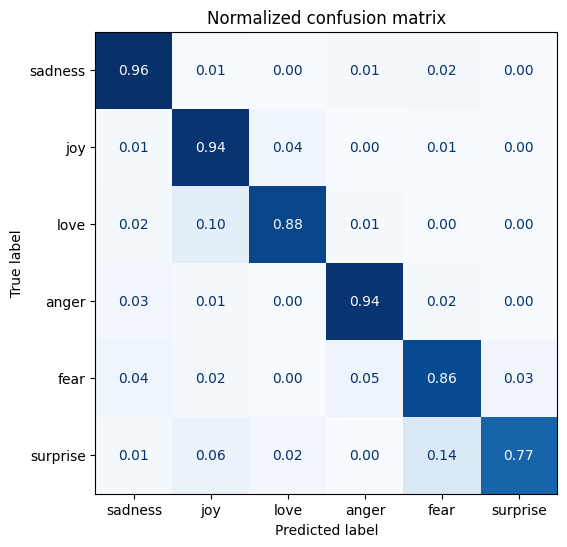

In [ ]:
plot_confusion_matrix(y_preds, y_valid, labels)

### A function to perform a forward pass and make batch predictions in the model (without calculating the gradient)

We compute loss using cross entropy.

In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
  inputs = {k:v.to(device) for k,v in batch.items()
            if k in tokenizer.model_input_names}

  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, axis=-1)
    loss = cross_entropy(output.logits, batch["label"].to(device),
                         reduction="none")

  return {"loss": loss.cpu().numpy(),
          "predicted_label": pred_label.cpu().numpy()}

### Change the dataset to torch tensors so we can get our predictions quickly

After we set the format, we get batched predictions, running 6 at a time (per thread)

In [ ]:
# Convert the whole dataset to PyTorch tensors
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

# Compute loss per example
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

### A function to return the string of a label for a given instance.

In [ ]:
def label_int2str(row):
  return emotions["train"].features["label"].int2str(row)

In [ ]:
# Print the list of label strings
emotions["train"].features["label"]

ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)

### @Author: Richard Yue -- Function to make a single prediction and return a tuple with the label and string

In [ ]:
def predict(text):
    with torch.no_grad():
      inputs = tokenizer(text, return_tensors="pt").to(device)
      output = model(**inputs)
      pred_label = torch.argmax(output.logits, axis=-1)[0].item()
      return (pred_label, label_int2str(pred_label))

### Running the inference function on a random example

In [ ]:
predict("I am quite annoyed to be here!")

(3, 'anger')

### Let's now view the examples with the highest loss to see where the model struggles

Convert to pandas so we can view the dataframe and sort by a given column.

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

### These are the "least certain" predictions.

It looks like there may be some errors in labeling, made by Amazon Mechanical Turk or whatever service did this job. Our classifier is still good, but we should be aware of this issue. There are also some sentences where even a human would have a hard time telling if it is love or joy. So we can't necessarily expect a machine to do this perfectly.

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1801,i feel that he was being overshadowed by the s...,love,sadness,6.169525
1963,i called myself pro life and voted for perry w...,joy,sadness,5.602628
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.377730
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.301639
882,i feel badly about reneging on my commitment t...,love,sadness,5.148751
1950,i as representative of everything thats wrong ...,surprise,sadness,5.030281
1509,i guess this is a memoir so it feels like that...,joy,fear,4.443334
1964,i feel vaguely cheated and a little amused,joy,sadness,4.341525
1111,im lazy my characters fall into categories of ...,joy,fear,4.291189
1683,i had applied for a job and they had assured m...,anger,joy,4.148665


### Now let's see where the model was "very certain."
It looks like sadness is the "easiest" prediction to make. Even for a human, we are unlikely to confuse this emotion, which is somewhat uniform and tends to be separate from most others.

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1466,i feel so ungrateful to be wishing this pregna...,sadness,sadness,0.014565
1310,i feel like an ungrateful asshole,sadness,sadness,0.014582
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.014790
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0.014840
1502,i feel ungrateful for stupid shit like,sadness,sadness,0.014924
1601,i feel so ungrateful when thinking saying thes...,sadness,sadness,0.014926
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.014987
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.015102
69,i have no extra money im worried all of the ti...,sadness,sadness,0.015144
1295,i feel a little damaged,sadness,sadness,0.015204
